# M-Test Notes

** Overview of M-test **
1. Implemented test that evaluates whether the forecast and the observations were generated from the same population distribution function. The null-hypothesis is that both the forecasts and observations were drawn from the same population distribution.
2. Evaluated with both Anderson-Darling and Kilmogorov-Smirnov tests. Prefer Anderson-Darling due to more sensitivty in the tails of the distribution. Downside with A-D is that p-values are somewhat meaningless as they might be extrapolated. Critical values are not.
3. Each catalog in stochastic-event-set is compared with observations and tested independently.
3. Using Fisher's combined test does not seem to provide sensible combinations of p-values for A-D tests.

** Talking Points **

1. Implemented M-test based on Kolmogorov-Smirnov, Anderson-Darling statistics on $M_w$ and 
   evaluated Fisher's combined test for combining test results.
2. Failed to reject null-hypothesis for majority of catalogs in stochastic event set.
3. Fisher's combined test does not provide sensible way to combine results for all tests. 
4. Distribution based tests OK for catalogs with large event counts, but for daily forecasts this approach will break
   down if there are no observed events. This extends to spatial tests as well. Indicates we might have different classes of tests. Distribution vs. event based tests. 
5. Alternative M-test available based on the N-test but broken into discrete magnitude bins. This would ask the question "What is the likelihood of observing $N_{obs}$ events given $N_{fore}$ forecasted events in magnitude bin $M_i$?". Is this a more useful question than distribution based tests?
6. Critical values of K-S test must be computed for discrete distributions. Assuming continuous results in incorrect type-I error rates.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from csep.utils.plotting import plot_mfd
import csep
import csep.utils.stats as cstats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Load Comcat catalog and UCERF3 forecasts

In [2]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > 4.0')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 16.491343021392822 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 4.010000228881836 and Max Magnitude: 6.300000190734863



In [3]:
# UCERF3 stochastic event set
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')

u3catalogs = []
for cat in csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs.append(cat.filter('magnitude > 4.0'))

## Towards an M-test

The M-test or Magnitude-test evaluates whether the magnitude-frequency distribution (MFD) of the observed catalog is statistically different than the forecast. There exist several techniques to compare whether two samples originate from the same population distribution; such as, Kolmogorov-Smirnov, Kramer-von Mises, or Anderson-Darling for continuous distributions and exact Multinomial test or Chi-square for discrete distributions. The Kolmogorov-Smirnov test is the most straightforward to implement because the distribution of the test statistic has an analytical distribution function; however, this test tends to be more sensitive to values in the middle of the probability distributions.

Two-sample non-parameteric tests for equality require computing empirical distribution functions from observed data sets. It's typical that magnitudes of earthquake forecasts and catalogs are discretized so that only certain observation are possible within a data set. The plots below show how the different discretizations effect the estimation of the KS statistics which is defined as $\sup{\lvert F(x)-G(x) \rvert}$, where $F(x)$ and $G(x)$ are empirical distribution functions.


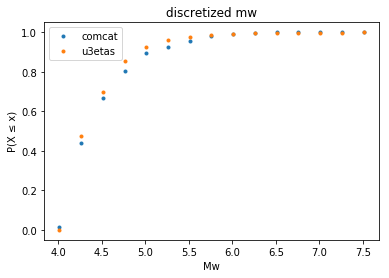

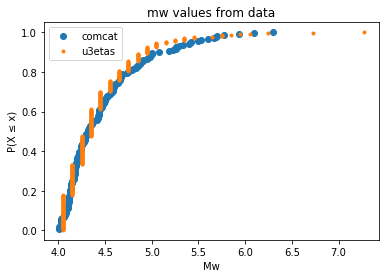

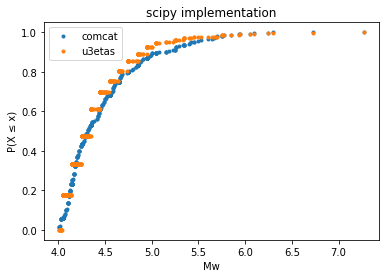

In [4]:
obs = comcat.get_magnitudes()
u3etas = u3catalogs[0].get_magnitudes()

# magnitude increment
dmw = 0.25
global_min = min([min(obs), min(u3etas)])
global_max = max([max(obs), max(u3etas)])

# magnitude bins
mws = arange(global_min, global_max+dmw, dmw)

# compute cdf function
# this computes ecdf everytime, can compute once and store. use different function
cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw), mws))
cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw), mws))

figure()
title("discretized mw")
plot(mws, cdf1, '.', label='comcat')
plot(mws, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

figure()
title("mw values from data")
plot(*cstats.ecdf(obs), 'o', label='comcat')
plot(*cstats.ecdf(u3etas), '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
legend()

# plotting ecdf from scipy implementation
d1 = sort(obs)
d2 = sort(u3etas)
n1 = d1.shape[0]
n2 = d2.shape[0]
d_all = concatenate([d1, d2])
cdf1 = searchsorted(d1, d_all, side='right') / n1
cdf2 = searchsorted(d2, d_all, side='right') / n2

figure()
title("scipy implementation")
plot(d_all, cdf1, '.', label='comcat')
plot(d_all, cdf2, '.', label='u3etas')
xlabel('Mw')
ylabel('P(X ≤ x)')
h = legend()

The top figure defines an arbitrary set of $M_w$ values to compute the ECDF so that the KS statistics is computed at consistent frequencies between the simulation and the data.

The middle figure defines cumulative frequencies at only points defined by the data. This operation produces an ambiguous KS statistic because there are multiple cumulative frequencies for each catalog value. We can immediately discard this approach.

The bottom figure shows the scipy implementation which pools the data under the null-hypothesis and computes cumulative frequencies for each value in the pooled data. This approach does not suffer the same issue as seen in the middle figure. However, by defining cumulative frequncies at values not observed in the catalog, the resulting KS statistics are potentially larger than they would be in the top case.

### Implementation of KS test using Discretized $M_w$ approach

To compare against the scipy implementation, we use the following implementation for the two-sample KS test based on computing the emprical distribution function at discretized values.

In [5]:
import scipy

def my_ks_2samp(data1, data2, dmw=0.1):
    # real version should force to be numpy arrays, etc.
    
    global_min = min([min(data1), min(data2)])
    global_max = max([max(data1), max(data2)])
    
    mws = arange(global_min, global_max+2*dmw, dmw)
    
    # precompute the ecdf so it only happens once
    cdf1_all = cstats.ecdf(data1)
    cdf2_all = cstats.ecdf(data2)
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1 = list(map(lambda mw: cstats.less_equal_ecdf(data1, mw, cdf=cdf1_all), mws))
    cdf2 = list(map(lambda mw: cstats.less_equal_ecdf(data2, mw, cdf=cdf2_all), mws))
        
    n1 = data1.shape[0]
    n2 = data2.shape[0]
    cdf1 = np.array(cdf1)
    cdf2 = np.array(cdf2)
    
    d = np.max(np.absolute(cdf1-cdf2))
    en = np.sqrt(n1 * n2 / (n1 + n2))
    
    # the constants are from stephens, 1974. seem to be simplification for computing sqrt(n). is this needed today?
    prob = scipy.stats.distributions.kstwobign.sf((en + 0.12 + 0.11 / en) * d)
    
    return(d, prob)

## Testing the M-test

1. Generate collection of RVs from known distribution, called $M_0$.
2. Generate $N$ collections of RVs from same distribution in 1, called $M_i$.
3. For all $M_i$, perform KS test and aggreate p-values using methods above.

Since we are comparing two collections of RVs sampled from the same distribution we expect that the individual and aggregate statistics from the KS test reflect this.

### For Scipy Implementation

rejected 28 out of 1000 simluations.
1824.3389756288736 0.9978316897100737


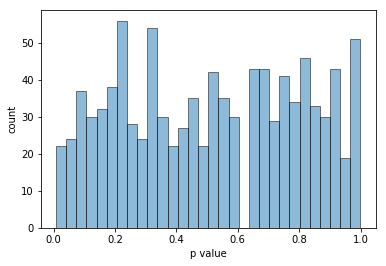

In [6]:
from scipy.stats import poisson, ks_2samp, norm
from scipy.stats.distributions import chi2

mu = 1.0
N = 1000
m0 = norm.rvs(mu, size=N)
mi = norm.rvs(mu, size=(N,N))
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = ks_2samp(m0, mi[idx])
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

Rejected 2 out of 1000 simluations.
936.5844845611516 1.0


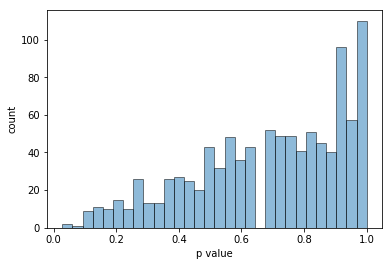

In [7]:
from scipy.stats import norm
from scipy.stats.distributions import chi2

mu = 0.0
N = 1000
m0 = norm.rvs(mu, size=N)
mi = norm.rvs(mu, size=(N,N))
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    d, p_value = my_ks_2samp(m0, mi[idx], dmw=0.1)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

print('Rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

The scipy implementation handles this test case appropriately. Based on this test, it appears that using a discrete distribution produces an incorrect type-I error rate for this test. 

Options: KS Test for discrete distributions or Anderson-Darling test.

## Testing the M-test using UCERF3

### For Scipy Implementation 

rejected 134 out of 9999 simluations.
11368.977749600006 1.0


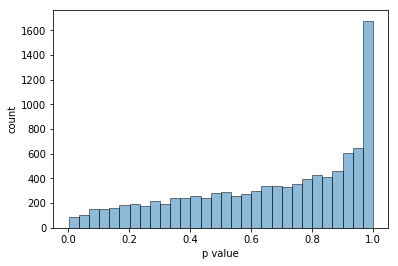

In [8]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = ks_2samp(m0_mws, mi_mws)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

### For discretized implementation

rejected 134 out of 9999 simluations.
11368.977749600006 1.0


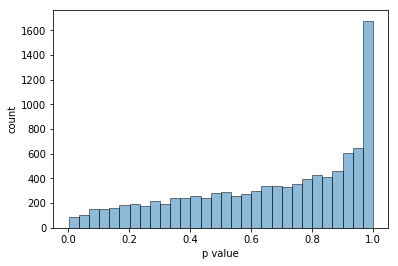

In [9]:
m0 = u3catalogs[0]
mi = u3catalogs[1:]
N = len(mi)
alpha = 0.05

p_values = []
rejections = 0
for idx in range(N):
    m0_mws = m0.get_magnitudes()
    mi_mws = mi[idx].get_magnitudes()
    d, p_value = my_ks_2samp(m0_mws, mi_mws, dmw=0.1)
    p_values.append(p_value)
    if p_value < alpha:
        rejections = rejections + 1

p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
xlabel('p value')
ylabel('count')

# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps. 
p_values[p_values >= 1.0] = 1.0

# 
print('rejected {} out of {} simluations.'.format(rejections, N))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

These tests show that the implementation from scipy provides test results consistent with our observations, and can be used to implement the M-test. Possible alternative solution could be Turnbull [1976]. 

The type-I error seems to be off for this particular test. We expect a type-I error rate equal to $\alpha$. In order to obtain realistic type-I error rates we would need to do this by simulation. See Discussion section.

## M-test of UCERF3-ETAS against observed data

rejected 19 out of 10000 simluations.
6759.777373206018 1.0


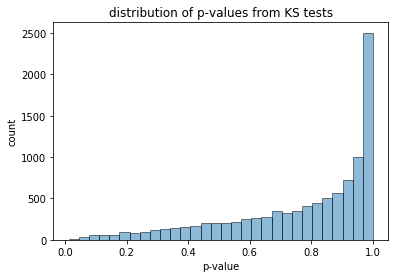

In [10]:
obs = comcat.get_magnitudes()
alpha = 0.05
N = len(u3catalogs)

rejections = 0
p_values = []

for u3cat in u3catalogs:
    mws = u3cat.get_magnitudes()
    d, p_val = my_ks_2samp(obs, mws, dmw=0.1)
    p_values.append(p_val)
    if p_val < alpha:
        rejections = rejections + 1
        
p_values = np.array(p_values)
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('p-value')
h = ylabel('count')
h = title('distribution of p-values from KS tests')

# display rejection
print('rejected {} out of {} simluations.'.format(rejections, len(u3catalogs)))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

## Conclusions

These notes show a possible implementation of the M-test based on Kolmogorov-Smirnov statistics. K-S statistics are based on estimating ECDFs and are very strict for large numbers of observations. This means that small deviations between the two result in rejecting the null-hypothesis.

It seems that this implementation might be too strict, for the overall purposes of the M-test. This raises the point that we might be interested in developing two-classes of tests: (1) developmental tests and (2) operational tests. These tests serve different purposes; namely, for model development and communication of forecast results. The developmental tests would be more severe and would be used to help modelers improve their models. The operational tests would be used to help communicate earthquake forecasts to the public and would likely be more qualitative in nature.

## Discussion

Our test implementation using the scipy implementation produces constisent results for both Poisson and UCERF-ETAS tests. However, on first glace, the test appears to be overly strict for the purposes of CSEP. The current M-test implementation asks "Do the forecast and the observation originate from the same distribution function?", but we are actually asking if the simulated and observed magnitude-frequency distributions are consistent with one another.

In some cases, we fail to reject the null-hypothesis simulations in the stochastic event set consistent with $\alpha$. Using Fisher's combined test we reject the collection of tests as a whole. This poses some questions in regards to this implementation of the M-test using the scipy implementation of KS statistics. 

The KS statistic is based on the the maximum absolute distance between the observed and cumulative distribution functions.

### Testing discretization of data before computing ECDF

The discretization above uses the definition of the CDF to estimate the rank statistics of data at pre-defined intervals. Here, we will try to discretize the data before computing the KS statistics to see if this introduces any biases. I'll use the scipy implementation of the KS test.

In [11]:
def discretize(data, bin_edges):
    """
    returns array with len(bin_edges) consisting of the discretized values from each bin. 
    instead of returning the counts of each bin, this will return an array with values 
    modified such that any value within bin_edges[0] <= x_new < bin_edges[1] ==> x_new.
    """
    n = data.shape[0]
    idx = digitize(data, bins=bin_edges)
    x_new = bin_edges[idx].copy()
    return x_new
    

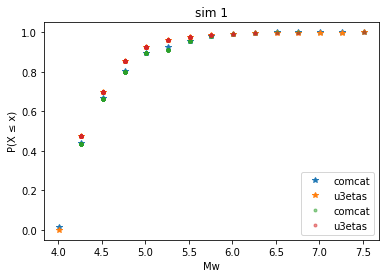

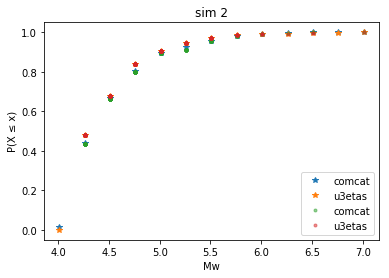

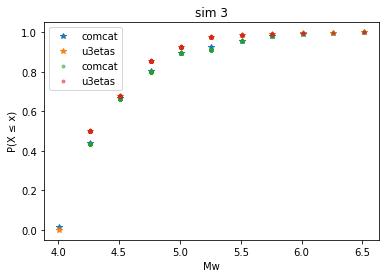

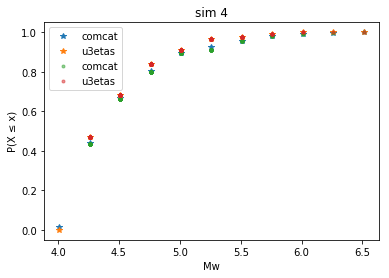

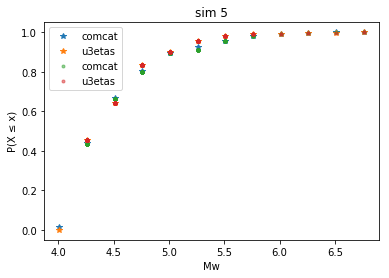

In [12]:
n_plots = 5
for idx in range(n_plots):
    # read catalogs
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3etas), min(obs)])
    global_max = max([max(u3etas), max(obs)])
    mws = arange(global_min, global_max+dmw, dmw)
    # discretize both data and forecast
    obs_disc = discretize(obs, mws)
    u3etas_disc = discretize(u3etas, mws)    
    # compute cdf based on KS method
    n1 = obs_disc.shape[0]
    n2 = u3etas_disc.shape[0]
    d1 = sort(obs_disc)
    d2 = sort(u3etas_disc)
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2
    
    # compute cdf function
    cdf1_p = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw), mws))
    cdf2_p = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw), mws))

    figure()
    title("sim {}".format(idx+1))
    plot(mws, cdf1_p, '*', label='comcat')
    plot(mws, cdf2_p, '*', label='u3etas')
    plot(d_all, cdf1, '.', label='comcat', alpha=0.5)
    plot(d_all, cdf2, '.', label='u3etas', alpha=0.5)
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

### Anderson-Darling test in place of K-S test synthetic test with true Null hypothesis 

/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: p-value capped: true value larger than 0.25
/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: p-value floored: true value smaller than 0.001


rejected 32818 out of 500000 simluations. type-I error rate = 0.065636
1686402.6417199182 0.0


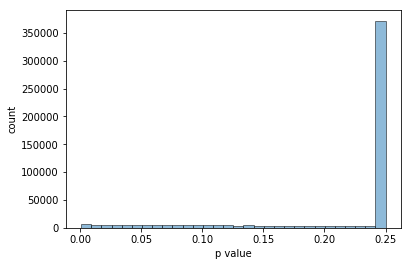

In [13]:
from scipy.stats import anderson_ksamp


alpha = 0.05
dmw = 0.1

p_values = []
rejections = 0
M = 500
for _ in range(M):
    idm = numpy.random.randint(0, high=9999)
    m0 = u3catalogs[idm]
    m0_mws = m0.get_magnitudes()
    mi = u3catalogs
    N = len(mi)
    idxs = numpy.random.randint(0, high=9999, size=1000)
    for idx in idxs:
        mi_mws = mi[idx].get_magnitudes()
        # create bins based on data (csep1 used fixed bins)
        global_min = min([min(m0_mws), min(mi_mws)])
        global_max = max([max(m0_mws), max(mi_mws)])
        mws = arange(global_min, global_max+2*dmw, dmw)
        m0_disc = discretize(m0_mws, mws)
        mi_disc = discretize(mi_mws, mws)
        a_stat, crit_vals, p_value = anderson_ksamp([m0_disc, mi_disc])
        # special for anderson-darling
        p_values.append(p_value)
        # crit_vals[2] corresponds to alpha=0.05
        if a_stat >= crit_vals[2]:
            rejections = rejections + 1

p_values = np.array(p_values)
# some issue with p_values, maybe related to scipy implementation of ks.sf() or eps or extrapolation. 
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
k = len(p_values)
xlabel('p value')
ylabel('count')
print('rejected {} out of {} simluations. type-I error rate = {}'.format(rejections, k, rejections/k))

# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*k)
print(chi_f, p_value)

### Anderson-Darling test against Data

/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: p-value capped: true value larger than 0.25
  from ipykernel import kernelapp as app
/Users/wsavran/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: p-value floored: true value smaller than 0.001
  from ipykernel import kernelapp as app


rejected 260 out of 10000 simluations.
30754.311360524163 0.0


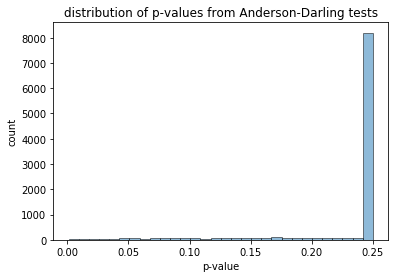

In [14]:
alpha = 0.05
dmw = 0.1
rejections = 0
p_values = []
obs = comcat.get_magnitudes()
for u3cat in u3catalogs:
    u3mws = u3cat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3mws), min(obs)])
    global_max = max([max(u3mws), max(obs)])
    mws = arange(global_min, global_max+2*dmw, dmw)
    # get discretized vectors
    u3_disc = discretize(u3mws, mws)
    obs_disc = discretize(obs, mws)
    a, crit, p_val = anderson_ksamp([u3_disc, obs_disc])
    p_values.append(p_val)
    # from scipy docs, idx=2 represents 5% significance
    if a >= crit[2]:
        rejections = rejections + 1
        
p_values = np.array(p_values)
# some issue with p_values, maybe related to scipy implementation of ks.sf() or extrapolation.
# use these values with care
# p_values[p_values >= 1.0] = 1.0
counts, bins, pathces = hist(p_values, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('p-value')
h = ylabel('count')
h = title('distribution of p-values from Anderson-Darling tests')

# display rejection
print('rejected {} out of {} simluations.'.format(rejections, len(u3catalogs)))
# combine statistical tests using fisher's combined probability test
chi_f = -2 * np.sum(np.log(p_values))
p_value = scipy.stats.distributions.chi2.sf(chi_f, 2*N)
print(chi_f, p_value)

Note: For the Anderson-Darling test, the p-value is meaningless. This implementation caps p-values that are computed by extrapolation.

### Visualizing the variability of the ECDF

The plots below show the first $N$ catalogs and the MFD from the data. 

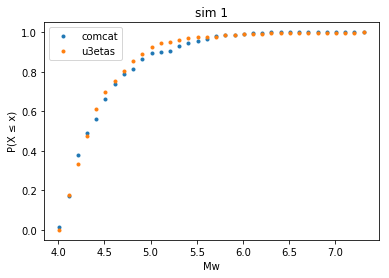

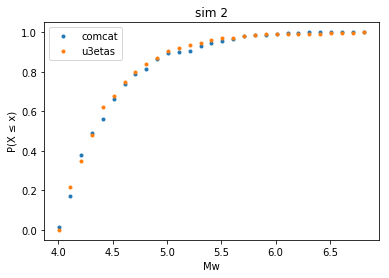

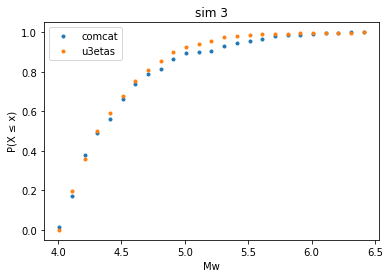

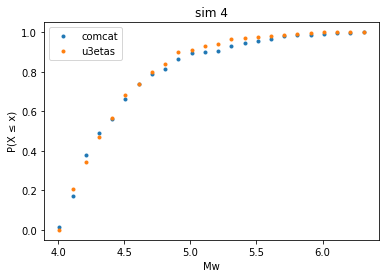

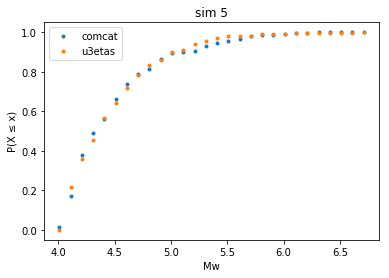

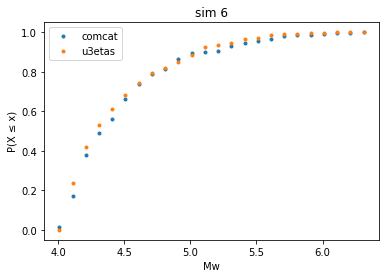

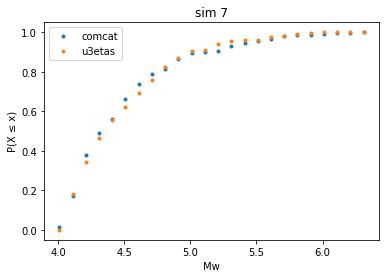

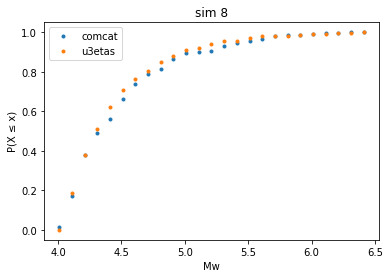

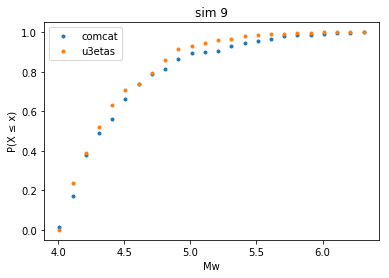

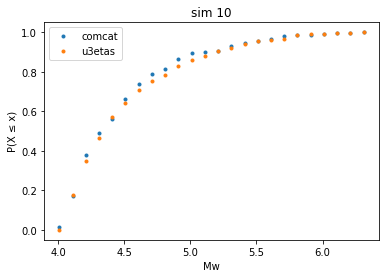

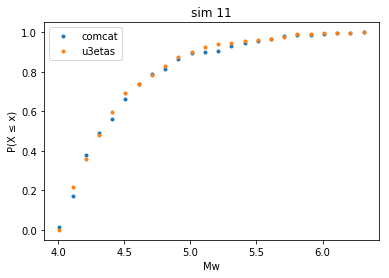

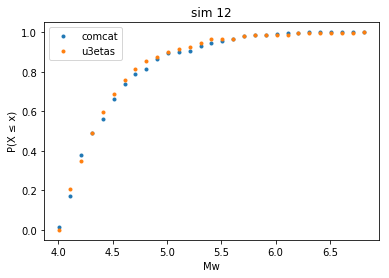

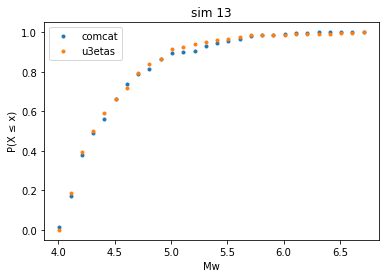

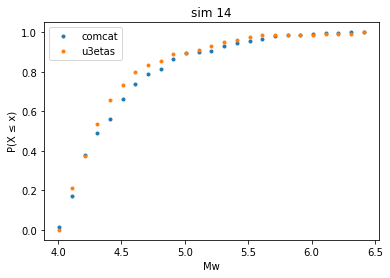

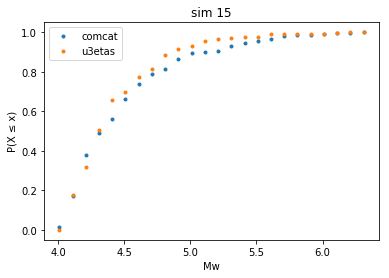

In [15]:
n_plots = 15
for idx in range(n_plots):
    # read catalogs
    u3etas = u3catalogs[idx].get_magnitudes()
    obs = comcat.get_magnitudes()
    # create bins based on data (csep1 used fixed bins)
    global_min = min([min(u3etas), min(obs)])
    global_max = max([max(u3etas), max(obs)])
    mws = arange(global_min, global_max+dmw, dmw)
    # discretize both data and forecast
    obs_disc = discretize(obs, mws)
    u3etas_disc = discretize(u3etas, mws)    
    # compute cdf based on KS method
    n1 = obs_disc.shape[0]
    n2 = u3etas_disc.shape[0]
    d1 = sort(obs_disc)
    d2 = sort(u3etas_disc)
    d_all = concatenate([d1, d2])
    cdf1 = searchsorted(d1, d_all, side='right') / n1
    cdf2 = searchsorted(d2, d_all, side='right') / n2
    
    # compute cdf function
    # this computes ecdf everytime, can compute once and store. use different function
    cdf1_a = cstats.ecdf(obs)
    cdf2_a = cstats.ecdf(u3etas)
    cdf1_p = list(map(lambda mw: cstats.less_equal_ecdf(obs, mw, cdf=cdf1_a), mws))
    cdf2_p = list(map(lambda mw: cstats.less_equal_ecdf(u3etas, mw, cdf=cdf2_a), mws))

    figure()
    title("sim {}".format(idx+1))
    plot(mws, cdf1_p, '.', label='comcat')
    plot(mws, cdf2_p, '.', label='u3etas')
    xlabel('Mw')
    ylabel('P(X ≤ x)')
    legend()

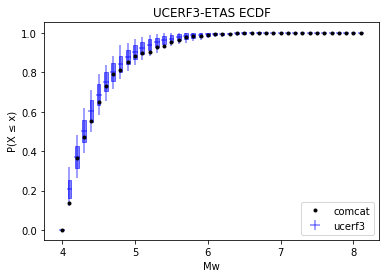

In [24]:
from matplotlib.collections import PatchCollection

def arbitrary_ecdf(x, vals):
    """
    returns the statement P(X ≤ x) for val in vals.
    vals must be monotonically increasing and unqiue.
    
    returns:
        tuple: sorted vals, and ecdf computed at vals
    """
    # precompute ecdf for x: returns(sorted(x), ecdf())
    ex, ey = cstats.ecdf(x)
    ecdf = numpy.array(list(map(lambda val: cstats.less_equal_ecdf(x, val, cdf=(ex, ey)), vals)))
    return (vals, ecdf)

def ks_from_ecdf(cdf1, cdf2, en):
    """
    computes k-s statistics given two cdfs: cdf1 and cdf2. 
    these should be defined at values observed in both data sets. 
    if used on discrete variables, the type-I error rates are too conservative.
    en = np.sqrt(n1*n2/float(n1+n2)); where n1 and n2 are the size of the original data
    """
    d = np.max(np.absolute(cdf1-cdf2))
    try:
        prob = stats.distributions.kstwobign.sf((en+0.12+0.11/en) * d)
    except:
        prob = 1.0
    return d, prob
    

mlow = 4.0
mhigh = 8.0
dmw = 0.1

# get list of magnitudes list of ndarray
u3etas_mws = list(map(lambda x: x.get_magnitudes(), u3catalogs))
obs_mw = comcat.get_magnitudes()

# get ecdf at arbitrary values
mws = np.arange(mlow, mhigh+2*dmw, dmw)

# get ecdf values 
u3etas_ecdf = np.array(list(map(lambda x: arbitrary_ecdf(x, mws), u3etas_mws)))
obs_ecdf = arbitrary_ecdf(obs_mw, mws)

fig = figure()
ax = fig.gca()
u3etas_ecdf = u3etas_ecdf
u3etas_median = np.median(u3etas_ecdf, axis=0)
u3etas_low = np.percentile(u3etas_ecdf, 2.5, axis=0)[1,:]
u3etas_high = np.percentile(u3etas_ecdf, 97.5, axis=0)[1,:]
u3etas_min = np.min(u3etas_ecdf, axis=0)[1,:]
u3etas_max = np.max(u3etas_ecdf, axis=0)[1,:]
u3etas_emin = u3etas_median[1,:]-u3etas_min
u3etas_emax = u3etas_max - u3etas_median[1,:]

# plot 95% range as rectangles
rectangles = []
for i in range(len(mws)):
    width = 0.5*dmw
    height = u3etas_high[i] - u3etas_low[i]
    xi = mws[i] - width / 2
    yi = u3etas_median[1,i] - height / 2
    rect = Rectangle((xi, yi), width, height)
    rectangles.append(rect)
pc = PatchCollection(rectangles, facecolor='blue', alpha=0.5, edgecolor='blue')
ax.add_collection(pc)
# plot whiskers
errorbar(u3etas_median[0], u3etas_median[1], xerr=0.8*dmw/2, yerr=[u3etas_emin, u3etas_emax], fmt=' ', label='ucerf3', color='blue', alpha=0.5)
plot(obs_ecdf[0], obs_ecdf[1], '.k', label='comcat')
legend(loc='lower right')
xlabel('Mw')
ylabel('P(X ≤ x)')
title("UCERF3-ETAS ECDF")
savefig('/Users/wsavran/Desktop/best_looking_mfd.pdf')

ECDF for stochastic event set as compared with the Comcat catalog. We show Comcat with black dots and the UCERF distributions are visualized with these modified box and whisker plots. The boxes contain 95 percent of the data and the whiskers represent the extremes of the stochastic event set.

We could implement a statistical test based around this figure that would compare the different magnitude bins independently. This allows us to deal with small numbers of events in catalogs.

## Distribution test implemented using empirical Cumulative Distribution Functions

In this section, we will consider how to implement a distribution test based on the empirical distribution of the test statistic. The previous tests explored in this document assume that each synthetic catalog of the stochastic event set is treated as an independent realization from a parent stochastic process. Thus, each comparison of an individual synthetic catalog with the observed catalog results in a single likelihood value based on the asymptotic distribution of the computed statistic. In this case, either the K-S statistics or the A-D statistic. Finally, the results are aggregated under the assumption that p-values from a true null-hypothesis are uniformly distributed. This method falls short by not properly treating the epistemic uncertainty of the simulation. 

To overcome this amongst other errors aggregating p-values, we will introduce an approach for all distribution based-tests that is based on an emprical distribution we will create a family of test statistics from the stochastic event set alone. This will represent the test distribution of some statistic, $s$. From this empirical distribution, we can compute the likelihood of observing the same statistic computed from the observed catalog based. Finally, we will compare the observed statistic against the empirical test distribution.

This procedure is general and can be applied to any statistic that we could computed based on a distribution from a catalog.

### Visualize Combined distribution and Comcat catalog

Here, we generate the combined distribution of magnitudes. In practice, the get_magnitudes() function to aggregate data points from the stochastic event set. This could something like inter-event times or cartesian distances from some point.

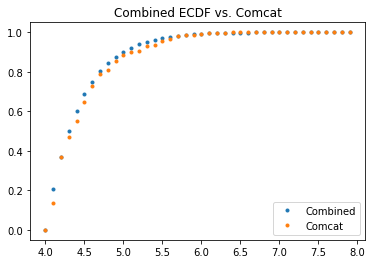

In [25]:
import functools
import operator

def flat_map_to_ndarray(l):
    out = np.array(functools.reduce(operator.iconcat, l, []))
    return out

# efficient way to concat a list of lists
catalog_data = [cat.get_magnitudes() for cat in u3catalogs]
combined = flat_map_to_ndarray(catalog_data)

# discretize the events
dmw = 0.1
mw_min = 4.0
mw_max = 8.0
mws = arange(mw_min, mw_max, dmw)
combined_ecdf = arbitrary_ecdf(combined, mws)
obs_ecdf = arbitrary_ecdf(comcat.get_magnitudes(), mws)

# visualize the combined distribution and the 
figure()
plot(*combined_ecdf, '.', label='Combined')
plot(*obs_ecdf, '.', label='Comcat')
legend(loc='lower right')
h = title('Combined ECDF vs. Comcat')

### Creating the empirical test distribution

To create the distribution for the test statistic, we will compute the K-S statistic which is defined as $\sup{\lvert F_i(x)-F^*(x) \rvert}$, where $F_i(x)$ is the cumulative distribution of the $i$th catalog of the stochastic event set and $F^*(x)$ is the empirical distribution of the combined set.

In this case, sup_dist() could be replaced by any statistic.

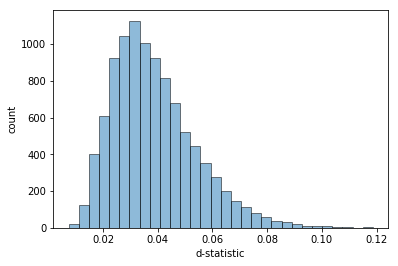

In [18]:
def sup_dist(cdf1, cdf2):
    """
    given two cumulative distribution functions, compute the supremum of the set of absolute distances.
    
    note:
        this function does not check that the ecdfs are ordered or balanced. beware!
    """
    return np.max(np.absolute(cdf2-cdf1))

# build test distribution
test_distribution = []
for data in catalog_data:
    test_ecdf = arbitrary_ecdf(data, mws)
    # ecdf is tuple() ex, cdf
    d = sup_dist(test_ecdf[1], combined_ecdf[1])
    test_distribution.append(d)
    
# visualize the test distribution
counts, bins, pathces = hist(test_distribution, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('d-statistic')
h = ylabel('count')

### Computing statistic from observed catalog

Here, we compute the same statistic from the observed catalog. Finally, we put it all together to compute $\delta_1$ and $\delta_2$ values from the test.

0.0481 0.9519


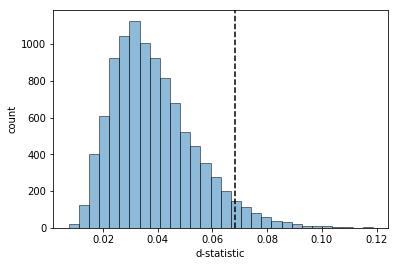

In [19]:
# compute same statistic from catalog
d_obs = sup_dist(obs_ecdf[1], combined_ecdf[1])

# compute delta 1 and delta 2
delta_1 = cstats.greater_equal_ecdf(test_distribution, d_obs)
delta_2 = cstats.less_equal_ecdf(test_distribution, d_obs)

# visualize the test distribution
counts, bins, pathces = hist(test_distribution, bins=30, edgecolor='black', alpha=0.5)
axvline(x=d_obs, color='black', linestyle='--')
h = xlabel('d-statistic')
h = ylabel('count')

print(delta_1, delta_2)

## M-test implementation with Cumulative Statistic

In this version, I replace the K-S statistic with a statistic $d^*$, where $d^*=\sum {(F(x)-F^*(x))}$, where the summation is over the set of distances. $F(x)$ and $F^*(x)$ are cumulative distribution functions.

0.0 1.0


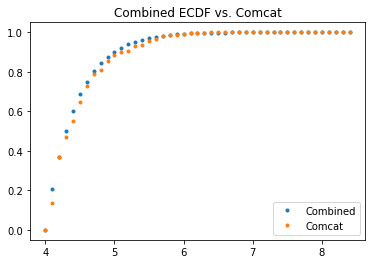

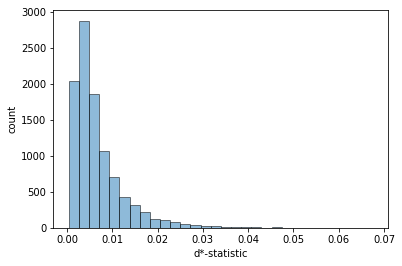

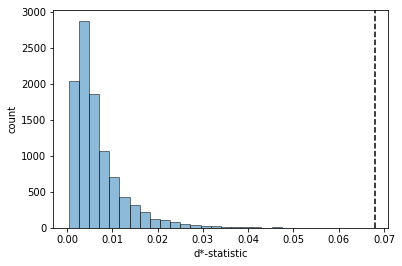

In [26]:
# efficient way to concat a list of lists
catalog_data = [cat.get_magnitudes() for cat in u3catalogs]
combined = flat_map_to_ndarray(catalog_data)

# discretize the events
dmw = 0.1
mw_min = 4.0
mw_max = 8.5
mws = arange(mw_min, mw_max, dmw)
combined_ecdf = arbitrary_ecdf(combined, mws)
obs_ecdf = arbitrary_ecdf(comcat.get_magnitudes(), mws)

# visualize the combined distribution and the 
figure()
plot(*combined_ecdf, '.', label='Combined')
plot(*obs_ecdf, '.', label='Comcat')
legend(loc='lower right')
h = title('Combined ECDF vs. Comcat')

def cum_sq_dist(cdf1, cdf2):
    """
    given two cumulative distribution functions, compute the cumulative sq. diff of the set of distances.
    
    note:
        this function does not check that the ecdfs are ordered or balanced. beware!
    """
    return np.sum((cdf2-cdf1)**2)

# build test distribution
test_distribution = []
for data in catalog_data:
    test_ecdf = arbitrary_ecdf(data, mws)
    # ecdf is tuple() ex, cdf
    d = cum_sq_dist(test_ecdf[1], combined_ecdf[1])
    test_distribution.append(d)
    
# visualize the test distribution
figure()
counts, bins, pathces = hist(test_distribution, bins=30, edgecolor='black', alpha=0.5)
h = xlabel('d*-statistic')
h = ylabel('count')

# compute same statistic from catalog
d_obs = sup_dist(obs_ecdf[1], combined_ecdf[1])

# compute delta 1 and delta 2
delta_1 = cstats.greater_equal_ecdf(test_distribution, d_obs)
delta_2 = cstats.less_equal_ecdf(test_distribution, d_obs)

# visualize the test distribution
figure()
counts, bins, pathces = hist(test_distribution, bins=30, edgecolor='black', alpha=0.5)
axvline(x=d_obs, color='black', linestyle='--')
h = xlabel('d*-statistic')
h = ylabel('count')

print(delta_1, delta_2)

## Inter-event time test based on same approach as above

Here, we implement a similar test based on the inter-event time distributions. These are computed using the difference in times between events in the stochastic event set. This test will use the same K-S statistic as described before.

0.458 0.542


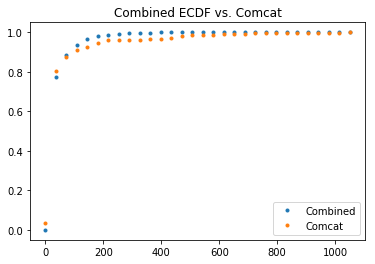

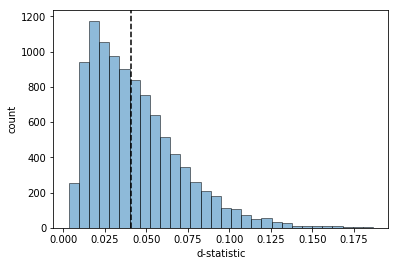

In [20]:
def get_inter_event_times(catalog, scale=1000):
    """
    returns the inter-event times from a given catalog. this should be implmented as a method on the catalog itself.
    
    the epoch times are listed in milliseconds, so scale allows us to turn this into a more meaningful quantity.
    """
    times = catalog.get_epoch_times()
    inter_times = np.diff(times)/scale
    return inter_times

milli_to_hours = 1000*60*60

# get combined distribution of inter-event times
catalog_data = list(map(lambda x: get_inter_event_times(x, scale=milli_to_hours), u3catalogs))
combined_times = flat_map_to_ndarray(catalog_data)

# get inter-event times from catalog
obs_times = get_inter_event_times(comcat, scale=milli_to_hours)

min_time = 0.0
max_time = np.max([np.max(np.ceil(combined_times)), np.max(np.ceil(obs_times))])

# build test_distribution with 30 data points. this was chosen arbitrarily. 
points = 30
tms = np.linspace(min_time, max_time, points)

# get combined ecdf and obs ecdf
combined_ecdf = arbitrary_ecdf(combined_times, tms)
obs_ecdf = arbitrary_ecdf(obs_times, tms)

# visualize the combined distribution and the 
figure()
plot(*combined_ecdf, '.', label='Combined')
plot(*obs_ecdf, '.', label='Comcat')
legend(loc='lower right')
h = title('Combined ECDF vs. Comcat')

# build test distribution
test_distribution = []
for data in catalog_data:
    test_ecdf = arbitrary_ecdf(data, tms)
    # ecdf is tuple() ex, cdf
    d = sup_dist(test_ecdf[1], combined_ecdf[1])
    test_distribution.append(d)

# compute test statistic from catalog
d_obs = sup_dist(obs_ecdf[1], combined_ecdf[1])

# visualize the test distribution against test statistic
figure()
counts, bins, pathces = hist(test_distribution, bins=30, edgecolor='black', alpha=0.5)
axvline(x=d_obs, color='black', linestyle='--')
h = xlabel('d-statistic')
h = ylabel('count')

# compute delta 1 and delta 2
delta_1 = cstats.greater_equal_ecdf(test_distribution, d_obs)
delta_2 = cstats.less_equal_ecdf(test_distribution, d_obs)
print(delta_1, delta_2)

## Next steps

* Focus efforts on developing spatial plots.
  * Optimize binning routines spatially.
  * Think about how to efficiently aggregate catalogs over both dimensions (space and time).
* Develop routine to compute M-test when $N_{sim}$ or $N_{obs}$ is low, this might be testing based off histograms.

## References

Turnbull, B. W. (1976). The empirical distribution function with arbitrarily grouped, censored and truncated data. *Journal of the Royal Statistical Society. Series B (Methodological)*, 290-295.